# Import of useful libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, silhouette_score, adjusted_rand_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from joblib import Parallel, delayed
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Preparation

Given classifiers understand better when the target variable is at least ordinal, we switch our target class to integers; then we start creating the train-test split

In [2]:
tweets=pd.read_csv('cleantweets.csv', index_col=0)

In [3]:
class_dict={'not_cyberbullying': 0, 
            'age': 1, 
            'ethnicity': 2, 
            'religion': 3, 
            'gender': 4, 
            'other_cyberbullying': 5
            }

In [4]:
warnings.filterwarnings('ignore')
for i in range(len(tweets)): 
    tweets['cyberbullying_type'][i]=int(class_dict[tweets['cyberbullying_type'][i]])

In [5]:
x, y=tweets['cleantext'], tweets['cyberbullying_type']

Now we want to try and decide how many words we should keep in our bag of words vocabulary; too many and BoW models could overfit, too little and it could not capture correctly patterns. As such we can start by plotting the frequency of each word: 

In [6]:
tweets_data=tweets['cleantext']

vectorizer=CountVectorizer()  # no args: no vocabulary size

x=vectorizer.fit_transform(tweets_data)

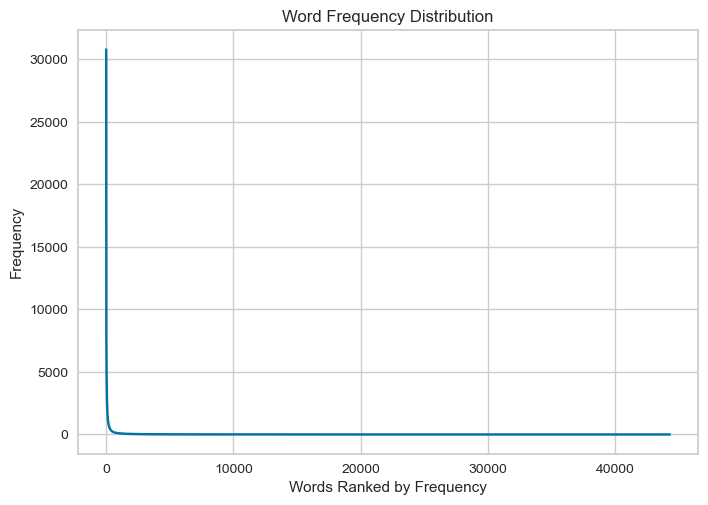

In [7]:
word_counts=x.toarray().sum(axis=0)
sorted_counts=sorted(word_counts, reverse=True)

plt.plot(sorted_counts)
plt.title("Word Frequency Distribution")
plt.xlabel("Words Ranked by Frequency")
plt.ylabel("Frequency")
plt.savefig(dpi=600, fname='BoW_novocab_size_wordfreq.png')
plt.show()

In [8]:
word_frequencies=np.asarray(x.sum(axis=0)).flatten()

words=vectorizer.get_feature_names_out()
word_freq_dict=dict(zip(words, word_frequencies))

sorted_word_freq=sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)

top_n=10
print(f"Top {top_n} most frequent words:")
for word, freq in sorted_word_freq[:top_n]:
    print(f"{word}: {freq}")

Top 10 most frequent words:
the: 30784
and: 24061
to: 23424
you: 18162
of: 15410
in: 14894
is: 14123
that: 11747
are: 9146
school: 8688


We see that many words are extremely common; this is because we have included stopwords. We can then try and remove stopwords to have a clearer vision:

In [9]:
vectorizer=CountVectorizer(stop_words=list(ENGLISH_STOP_WORDS))  

x=vectorizer.fit_transform(tweets_data)

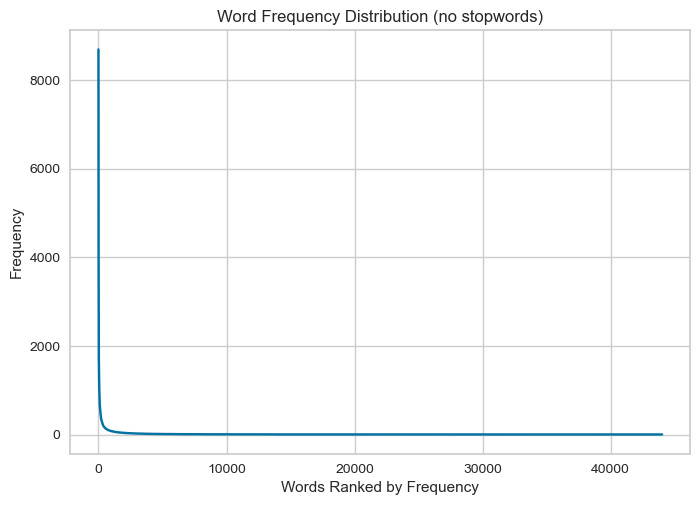

In [10]:
word_counts=x.toarray().sum(axis=0)
sorted_counts=sorted(word_counts, reverse=True)

plt.plot(sorted_counts)
plt.title("Word Frequency Distribution (no stopwords)")
plt.xlabel("Words Ranked by Frequency")
plt.ylabel("Frequency")
plt.savefig(dpi=600, fname='BoW_wordfreq_nostopwords.png')
plt.show()

In [11]:
word_frequencies=np.asarray(x.sum(axis=0)).flatten()

words=vectorizer.get_feature_names_out()
word_freq_dict=dict(zip(words, word_frequencies))

sorted_word_freq=sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)

top_n=10
print(f"Top {top_n} most frequent words:")
for word, freq in sorted_word_freq[:top_n]:
    print(f"{word}: {freq}")

Top 10 most frequent words:
school: 8688
like: 5815
fuck: 5199
high: 5086
people: 4789
dumb: 4787
bullied: 4653
just: 4562
im: 4452
dont: 4351


Once again, given the distribution of words levels off really quickly, we can try and understand how many words actually have a low frequency:

In [12]:
i=len(sorted_counts)-1
while i>0:
    if sorted_counts[i]>1:
        break
    i-=1
print(i)

19274


In [18]:
i=len(sorted_counts)-1
while i>0:
    if sorted_counts[i]>3:
        break
    i-=1
print(i)

11036


In [17]:
i=len(sorted_counts)-1
while i>0:
    if sorted_counts[i]>4:
        break
    i-=1
print(i)

9368


This means we for sure have to limit vocabulary size; one thing we can do is impose a limit on vocabulary size being 10000 words (frequency between 3 and 4):

In [34]:
vectorizer=CountVectorizer(max_features=10000, stop_words=list(ENGLISH_STOP_WORDS))
x, y=tweets['cleantext'], tweets['cyberbullying_type']
x_train, x_test, y_train, y_test=train_test_split(x, y, random_state=920) # train test split by default is 0.75 0.25
x_train_vec=vectorizer.fit_transform(x_train)
x_test_vec=vectorizer.transform(x_test)

One more thing to help with the model is to convert y_train and y_test to plain scalar arrays because otherwise the classifier will not be able to identify them and also reset their indices or else we won't be able to match them to original x values

In [35]:
y_train=y_train.reset_index(drop=True)  # reset index because otherwise the index will be the same as the original dataframe
y_test=y_test.reset_index(drop=True)  
y_train=y_train.astype('int') # convert to int because the classifier expects int
y_test=y_test.astype('int')

# Classification

## Xgboost

We now can test our first model, which will be XGBoost; first we can do a simple 7 fold cross validation on the dataset, then we'll try and compare our results on the test set:

In [36]:
n_folds=7
skf=StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)
xgb_clf=XGBClassifier(objective='multi:softmax', num_class=6, random_state=4)

def evaluate_fold(train_idx, test_idx, x, y, model): # defining a function to evaluate the model while computing all the metrics in parallel
    x_train, x_test=x[train_idx], x[test_idx]
    y_train, y_test=y[train_idx], y[test_idx]
    model.fit(x_train, y_train)
    y_pred=model.predict(x_test)
    
    metrics={
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
    }
    return metrics

results=Parallel(n_jobs=-1)(
    delayed(evaluate_fold)(train_idx, test_idx, x_train_vec, y_train, xgb_clf) # parallelization of cross validation tasks
    for train_idx, test_idx in skf.split(x_train_vec, y_train)
)

mean_metrics={metric: np.mean([result[metric] for result in results]) for metric in results[0].keys()}
for metric, value in mean_metrics.items():
    print(f"Mean {metric.capitalize()}: {value:.4f}")

Mean Accuracy: 0.8353
Mean Precision: 0.8492
Mean Recall: 0.8353
Mean F1: 0.8333


In [37]:
xgb_clf.fit(x_train_vec, y_train)
y_pred_xgb=xgb_clf.predict(x_test_vec)

In [38]:
print("XGBoost Accuracy:", accuracy_score(list(y_test.values), y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(list(y_test.values), y_pred_xgb))
print(class_dict)

XGBoost Accuracy: 0.834597072826662
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.41      0.50      1723
           1       0.99      0.97      0.98      2012
           2       0.98      0.97      0.98      1899
           3       0.96      0.94      0.95      1974
           4       0.91      0.83      0.87      1918
           5       0.56      0.83      0.67      1816

    accuracy                           0.83     11342
   macro avg       0.84      0.83      0.82     11342
weighted avg       0.85      0.83      0.83     11342

{'not_cyberbullying': 0, 'age': 1, 'ethnicity': 2, 'religion': 3, 'gender': 4, 'other_cyberbullying': 5}


## MLP

We now can test our second model, which will be MLP; first we can do a simple 7 fold cross validation on the dataset, then we'll try and compare our results on the test set:

In [39]:
n_folds=7
skf=StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)
mlp_clf=MLPClassifier(activation='relu', solver='adam', learning_rate='adaptive', random_state=4)

def evaluate_fold(train_idx, test_idx, x, y, model): 
    x_train, x_test=x[train_idx], x[test_idx]
    y_train, y_test=y[train_idx], y[test_idx]
    model.fit(x_train, y_train)
    y_pred=model.predict(x_test)
    
    metrics={
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
    }
    return metrics

results=Parallel(n_jobs=-1)(
    delayed(evaluate_fold)(train_idx, test_idx, x_train_vec, y_train, mlp_clf) 
    for train_idx, test_idx in skf.split(x_train_vec, y_train)
)

mean_metrics={metric: np.mean([result[metric] for result in results]) for metric in results[0].keys()}
for metric, value in mean_metrics.items():
    print(f"Mean {metric.capitalize()}: {value:.4f}")

Mean Accuracy: 0.7903
Mean Precision: 0.7943
Mean Recall: 0.7903
Mean F1: 0.7921


In [40]:
mlp_clf=MLPClassifier(activation='relu', solver='adam', learning_rate='adaptive', random_state=4)
mlp_clf.fit(x_train_vec, y_train)
y_pred_mlp=mlp_clf.predict(x_test_vec)

In [41]:
print("MLP Accuracy:", accuracy_score(list(y_test.values), y_pred_mlp))
print("MLP Classification Report:\n", classification_report(list(y_test.values), y_pred_mlp))
print(class_dict)

MLP Accuracy: 0.7858402398166108
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.47      0.47      1723
           1       0.97      0.95      0.96      2012
           2       0.97      0.95      0.96      1899
           3       0.95      0.93      0.94      1974
           4       0.84      0.82      0.83      1918
           5       0.51      0.53      0.52      1816

    accuracy                           0.79     11342
   macro avg       0.78      0.78      0.78     11342
weighted avg       0.79      0.79      0.79     11342

{'not_cyberbullying': 0, 'age': 1, 'ethnicity': 2, 'religion': 3, 'gender': 4, 'other_cyberbullying': 5}


## Support Vector Machine

We now can test our third model, which will be a support vector machine; first we can do a simple 7 fold cross validation on the dataset, then we'll try and compare our results on the test set:

In [42]:
n_folds=7
skf=StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)
svm_clf=SVC(kernel='rbf', random_state=4) 

def evaluate_fold(train_idx, test_idx, x, y, model): 
    x_train, x_test=x[train_idx], x[test_idx]
    y_train, y_test=y[train_idx], y[test_idx]
    model.fit(x_train, y_train)
    y_pred=model.predict(x_test)
    
    metrics={
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
    }
    return metrics

results=Parallel(n_jobs=-1)(
    delayed(evaluate_fold)(train_idx, test_idx, x_train_vec, y_train, svm_clf) 
    for train_idx, test_idx in skf.split(x_train_vec, y_train)
)

mean_metrics={metric: np.mean([result[metric] for result in results]) for metric in results[0].keys()}
for metric, value in mean_metrics.items():
    print(f"Mean {metric.capitalize()}: {value:.4f}")

Mean Accuracy: 0.8277
Mean Precision: 0.8415
Mean Recall: 0.8277
Mean F1: 0.8261


In [43]:
svm_clf=SVC(kernel='rbf', random_state=4)
svm_clf.fit(x_train_vec, y_train)
y_pred_svm=svm_clf.predict(x_test_vec)

In [44]:
print("SVM Accuracy:", accuracy_score(list(y_test.values), y_pred_svm))
print("SVM Classification Report:\n", classification_report(list(y_test.values), y_pred_svm))
print(class_dict)

SVM Accuracy: 0.8241050961029801
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.42      0.49      1723
           1       0.98      0.96      0.97      2012
           2       0.97      0.97      0.97      1899
           3       0.95      0.94      0.94      1974
           4       0.92      0.80      0.85      1918
           5       0.55      0.81      0.66      1816

    accuracy                           0.82     11342
   macro avg       0.83      0.82      0.81     11342
weighted avg       0.84      0.82      0.82     11342

{'not_cyberbullying': 0, 'age': 1, 'ethnicity': 2, 'religion': 3, 'gender': 4, 'other_cyberbullying': 5}


# Clustering

In [45]:
x_vec=vectorizer.fit_transform(tweets_data)

We are clustering because we want to check whether the resulting clusters will match or not the original classification; this will show us especially if classes overlap and, as a consequence, if some of the missclassified tweets are because of this "overlap". Moreover this can tell us more about the structure of hate speech in itself. 


The first thing we need to assess to proceed is the number of clusters K; to do this we decided to use the silhouette score, mainly because it does not rely on ground truths as required by what said above but also because it does not rely on the "structure" of the cluster not overlapping with other clusters or having a clear variance structure within its data. 

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

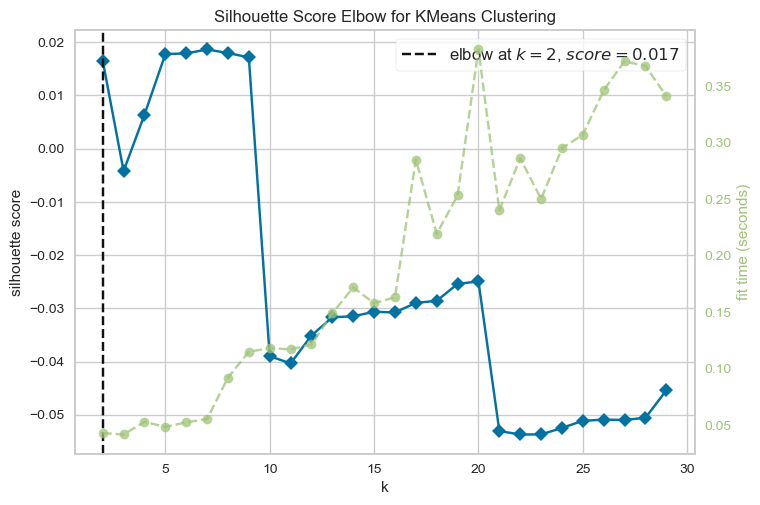

In [52]:
visualizer=KElbowVisualizer(KMeans(random_state=4), k=(2,30), metric='silhouette')
visualizer.fit(x_vec)
visualizer.show(outpath='silhouette_BOW.png', dpi=600, bbox_inches='tight')

Now remember that the silhouette Elbow method looks for when increasing K gives us diminishing returns considering also fit time in seconds. We do not care about fit time, and as such we shall choose K only based on the maximum this plot shows, which is for K=7.

Just as a double check, we can also look for the "distortion" as a metric, although we already know it will probably follow some multiple of the squared inverse of K, given that K is a good proxy for flexibility of the model and hence it's also a good proxy of the squared variance of the model.

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

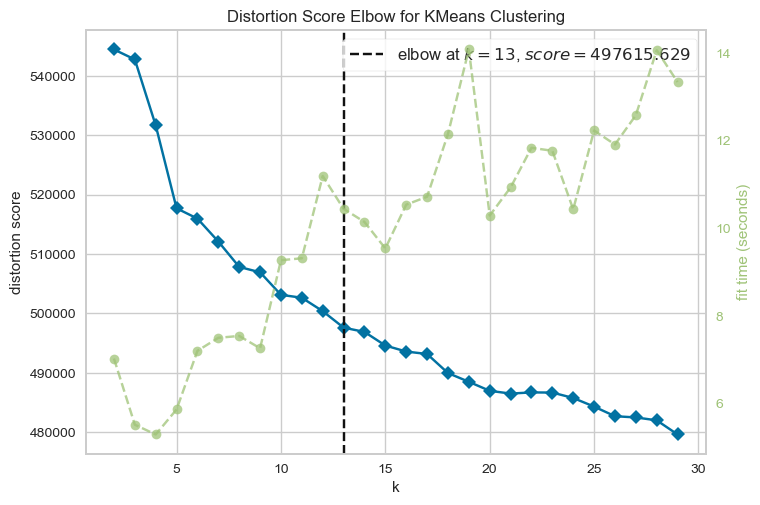

In [53]:
visualizer=KElbowVisualizer(KMeans(random_state=4), k=(2,30), metric='distortion')
visualizer.fit(np.asarray(x_vec.todense()))
visualizer.show(outpath='distortion_BOW', dpi=600, bbox_inches='tight')

Choosing K=7 gives us also some advantage on the variance side given it already has fallen off quite a bit by then.

In [48]:
num_clusters=7  
kmeans=KMeans(n_clusters=num_clusters, random_state=4)
kmeans.fit(x_vec)

clusters=kmeans.predict(x_vec)

tweets['cluster']=clusters

An interesting plot we can take a look at is, for starters, frequency of tweets within clusters. We would expect this to be approximately constant if the classification was to follow our "ground truth":

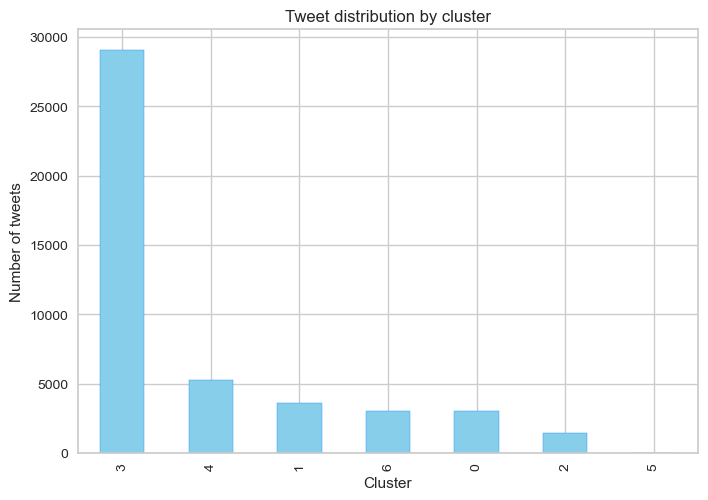

In [49]:
tweets['cluster'].value_counts().plot(kind='bar', color='skyblue', edgecolor='dodgerblue')
plt.title('Tweet distribution by cluster')
plt.xlabel('Cluster'),
plt.ylabel('Number of tweets')
plt.savefig(dpi=600, fname='tweet_by_cluster_BOW.png')
plt.show()

Another metric we can compute is the Silhouette Score and the Adjusted Rand Index, which is basically a count of how many tweets were classified "correctly" based on our ground truth, accounting for random chance.

In [50]:
silhouette=silhouette_score(x_vec, kmeans.labels_)
print(f"Silhouette Coefficient: {silhouette:.2f}")

rand_index=adjusted_rand_score(tweets['cyberbullying_type'], tweets['cluster'])
print(f"Rand Index: {rand_index:.2f}")

Silhouette Coefficient: 0.02
Rand Index: 0.14


Lastly, one interesting thing to do to see if clusters are well separated is to plot them along Principal Components Axis:

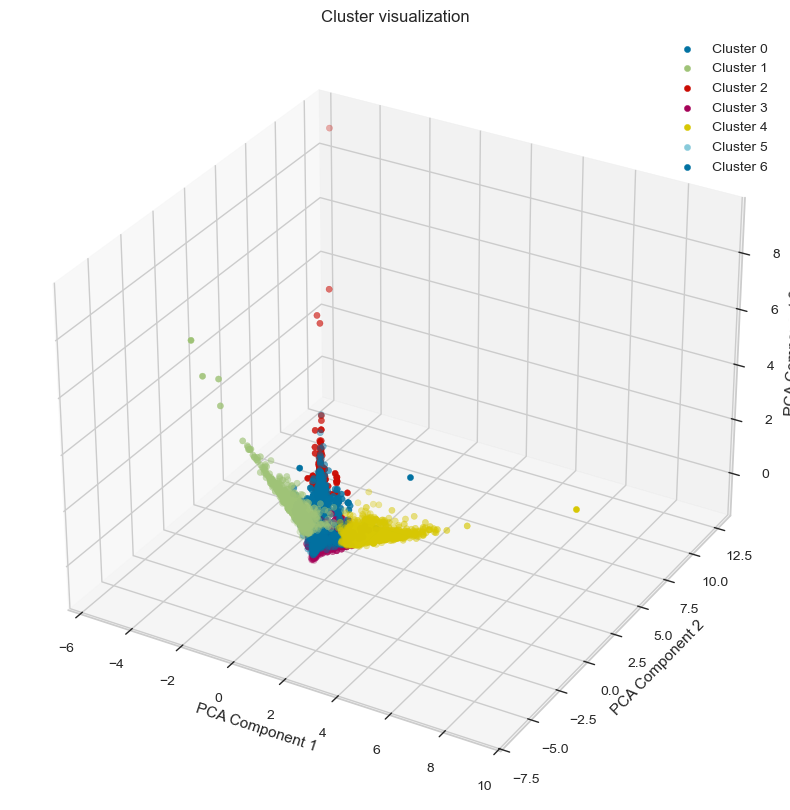

In [51]:
pca=PCA(n_components=3)
x_pca=pca.fit_transform(x_vec.toarray())

fig=plt.figure(figsize=(15, 10))
ax=fig.add_subplot(111, projection='3d')
for cluster in range(num_clusters):
    ax.scatter(x_pca[tweets['cluster']==cluster, 0], x_pca[tweets['cluster']==cluster, 1], x_pca[tweets['cluster']==cluster, 2], label=f'Cluster {cluster}')
ax.set_title('Cluster visualization')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.savefig(dpi=600, fname='PCA_BOW.png')
plt.show()